# Using MobileNetV2 (transfer learning approach)

MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes. It's 155 layers deep and very efficient for object detection / image segmentation / classification tasks.

The architecture has three defining characteristics:
*   Depthwise separable convolutions (reduces number of parameters and operations for convolution)
  * Depthwise convolution: calculates an intermediate result by convolving on each of the channels independently
  * Pointwise convolution: merges the outputs of the previous step into one layer. Applied multiple times (# of filter)

*   Thin input and output bottlenecks that preserve important information on either end of the block
*   Shortcut connections between bottleneck layers

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, similar to the ones in traditional resnets, serve the purpose of speeding up training and improving predictions. They skip over the intermediate convolutions and connect the bottleneck layers. 

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <font color='purple'> <b>MobileNetV2 Architecture</b> <br> Inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

    
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## Loading Images as data
* Using `image_data_set_from_directory()` to generate dataset from images stored on disk. 
Subset takes two values {'training', 'validation'}. Setting matching seeds ensures that training and validation sets don't overlap. 


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "data/alpaca_data/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2, subset='validation', seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [3]:
print(train_dataset.class_names)              # automatically infers these from folder names
class_names = train_dataset.class_names

['alpaca', 'not alpaca']


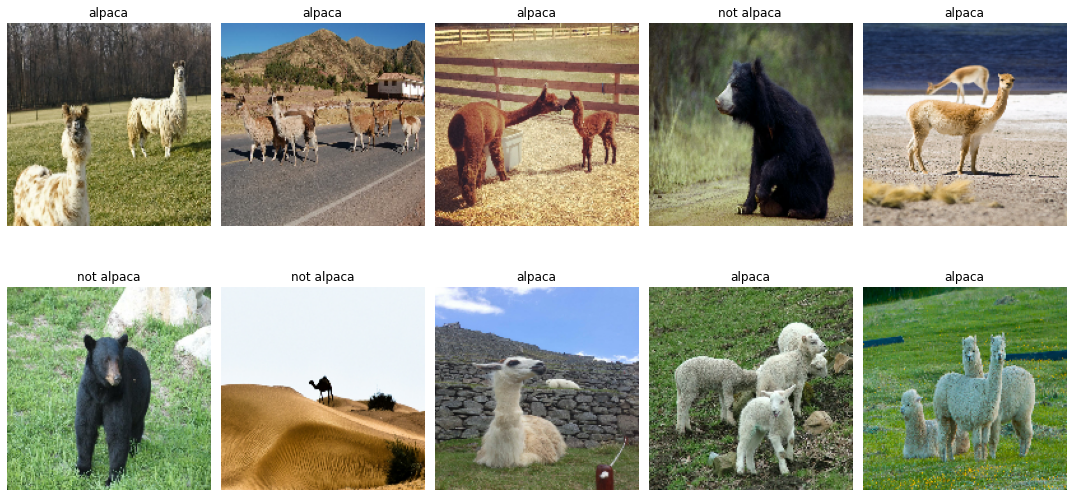

In [4]:
plt.figure(figsize=(15, 8))
for images, labels in train_dataset.take(1):  # 1 batch
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()

**Pre-Fetch** to memory read - Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed. Because the iteration is streaming, the data doesn't need to fit into memory.We can either set the prefetch value manually, or use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically (sets value dynamically at runtime).

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Augmenting Data

**Augmentation** - Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing [layers](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [6]:
def augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

(160, 160, 3)
(1, 160, 160, 3)


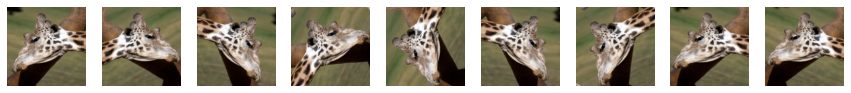

In [7]:
data_augmentation = augmenter()

for image, _ in train_dataset.take(1):
    first_image = image[0]
    print(first_image.shape)
    
    # creates dim-0 which represents # of samples (with default value = 1)
    first_image = tf.expand_dims(first_image, axis=0)
    print(first_image.shape)
    
    plt.figure(figsize=(15, 5))
    for i in range(9):
        plt.subplot(1, 9, i + 1)
        augmented_image = data_augmentation(first_image) 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## MobileNetV2
  
* Load pretrained weights from `ImageNet`
* Use original model's input preprocessing (it was trained on values \[-1,1])
* Customizing the output layer of the model

---

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)   #concatenating tuples
print(IMG_SHAPE)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

print('Number of layers: ', len(base_model.layers))

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

(160, 160, 3)
Number of layers:  156


In [9]:
# base_model.summary()

### Using "as-is" doesn't make sense

In [10]:
image_batch, label_batch = next(iter(train_dataset))
print("Actual labels: ", label_batch[:5])


image_proc = preprocess_input(image_batch[:5])   # Only using 10 images
model_pred = base_model(image_proc)
print("Model output: ", model_pred.shape) # Model provides probabilities for 1000 classes

Actual labels:  tf.Tensor([1 0 0 1 1], shape=(5,), dtype=int32)
Model output:  (5, 1000)


In [11]:
tf.keras.applications.mobilenet_v2.decode_predictions(model_pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.10330004),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883586)],
 [('n02125311', 'cougar', 0.16546737), ('n02389026', 'sorrel', 0.10764276)],
 [('n02437312', 'Arabian_camel', 0.29232737),
  ('n02437616', 'llama', 0.2771354)],
 [('n03944341', 'pinwheel', 0.3115498), ('n03047690', 'clog', 0.052499905)],
 [('n02454379', 'armadillo', 0.7310718), ('n01990800', 'isopod', 0.038719844)]]

### Customizing & training the Final Layer of the model

In [12]:
base_model.input

<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>

In [13]:
base_model.layers[-5:]

In [14]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=augmenter()):
    ''' Customize MobileNetV2 for binary classification
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns: tf.keras.model
    '''
       
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,  # Drop top layer
                                                   weights='imagenet') # From imageNet
    base_model.trainable = False               # freeze the base model 

    inputs = tf.keras.Input(shape=input_shape) # same dim as imagenet
    x = data_augmentation(inputs)              # apply data augmentation    
    x = preprocess_input(x)                    # use data preprocessing from base model
    x = base_model(x, training=False)          # to avoid tracking statistics for batch norm layer
    
    # add the new Binary classification layers
    x = tfl.GlobalAveragePooling2D()(x)        # global avg pooling to summarize info in each channel
    x = tfl.Dropout(rate=0.2)(x)               # dropout regularization to avoid overfitting
        
    outputs = tfl.Dense(1, activation='linear')(x)  # prediction layer
    model = tf.keras.Model(inputs, outputs)
    return model

In [17]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)
model2.layers

In [18]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 5s 319ms/step - loss: 0.7409 - accuracy: 0.5687 - val_loss: 0.6708 - val_accuracy: 0.5692
Epoch 2/5
9/9 [==============================] - 2s 244ms/step - loss: 0.5342 - accuracy: 0.7137 - val_loss: 0.4580 - val_accuracy: 0.6615
Epoch 3/5
9/9 [==============================] - 2s 249ms/step - loss: 0.5134 - accuracy: 0.7290 - val_loss: 0.4243 - val_accuracy: 0.6462
Epoch 4/5
9/9 [==============================] - 2s 230ms/step - loss: 0.4636 - accuracy: 0.7252 - val_loss: 0.3803 - val_accuracy: 0.6615
Epoch 5/5
9/9 [==============================] - 2s 237ms/step - loss: 0.3937 - accuracy: 0.7977 - val_loss: 0.3118 - val_accuracy: 0.7692


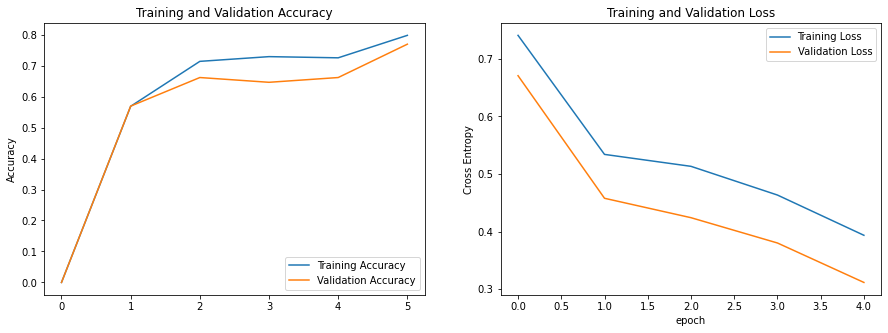

In [25]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right'); plt.ylabel('Accuracy'); plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy'); plt.title('Training and Validation Loss'); plt.xlabel('epoch')
plt.show()

### Re-training last few layers of the model

In [26]:
# base model is at index 4
base_model = model2.layers[4]
print(len(base_model.layers))

154


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 120
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [28]:
base_learning_rate = 0.001
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1*base_learning_rate),
              metrics=['accuracy'])

In [29]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 6s 349ms/step - loss: 0.5407 - accuracy: 0.7634 - val_loss: 0.2312 - val_accuracy: 0.9538
Epoch 6/10
9/9 [==============================] - 3s 275ms/step - loss: 0.3395 - accuracy: 0.8244 - val_loss: 0.1971 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 3s 289ms/step - loss: 0.2404 - accuracy: 0.9046 - val_loss: 0.1169 - val_accuracy: 0.9385
Epoch 8/10
9/9 [==============================] - 3s 298ms/step - loss: 0.2083 - accuracy: 0.9351 - val_loss: 0.0825 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 3s 288ms/step - loss: 0.1626 - accuracy: 0.9427 - val_loss: 0.0738 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 3s 276ms/step - loss: 0.0997 - accuracy: 0.9733 - val_loss: 0.0723 - val_accuracy: 0.9692


In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

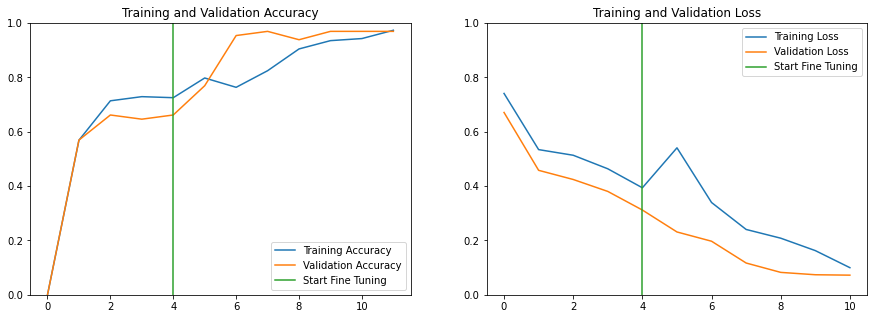

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right'); plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right'); plt.title('Training and Validation Loss')
plt.show()

In [41]:
type(model2)

keras.engine.functional.Functional

In [52]:
model2.evaluate(validation_dataset)

3/3 [==============================] - 0s 98ms/step - loss: 0.0723 - accuracy: 0.9692


[0.07226331532001495, 0.9692307710647583]

In [90]:
# Data gets shuffled every time you read it
# https://stackoverflow.com/questions/71706820/tensorflow-dataset-order-appears-randomised-when-iterating-via-for-loop

y_pred = []
y_true = []
for images, labels in validation_dataset.take(3):
    for i in range(len(labels)):
        y_true.append(labels[i].numpy())
        img = tf.expand_dims(images[i], axis=0)
        y_pred.append(model2.predict(img));

1/1 [==============================] - 0s 25ms/step


In [91]:
y_true = np.array(y_true)

y_pred = np.squeeze(y_pred)
y_pred = (1/(1+np.exp(-y_pred))).ravel()
y_class = np.round(y_pred)

print(classification_report(y_true, y_class))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.97      0.97      0.97        40

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65

